# Q1

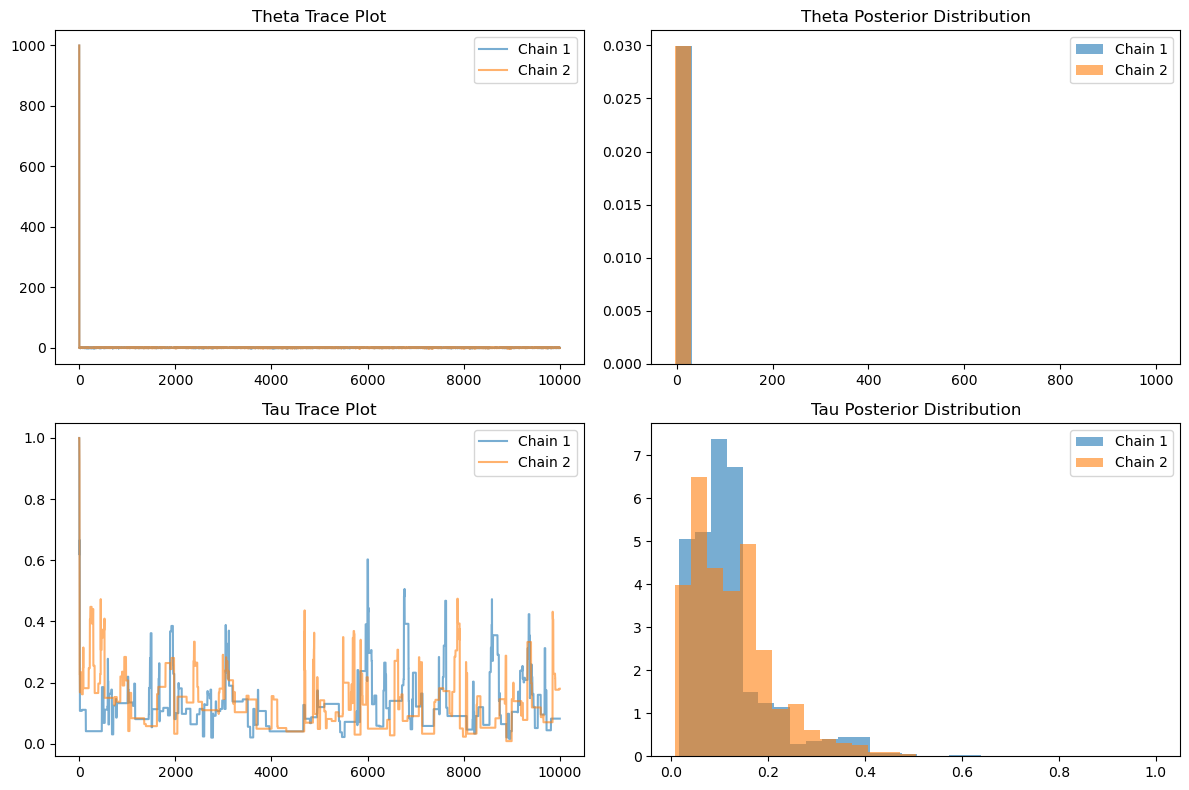

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# -----------------------------
# 1. Generate data
# -----------------------------
n = 30      # Sample size
true_mean = 0
true_sd = 1
x = stats.norm(loc=true_mean, scale=true_sd).rvs(size=n)

# -----------------------------
# 2. Set prior hyperparameters
# -----------------------------
theta0 = 0       # Prior mean for theta
tau0_sq = 1      # Prior variance for theta
alpha = 2        # Shape parameter for tau's Gamma prior
lambda_ = 1      # Rate parameter for tau's Gamma prior

# -----------------------------
# 3. Metropolis within Gibbs settings
# -----------------------------
num_chains = 2       # Number of chains
num_samples = 10000   # Iterations per chain

theta = np.zeros((num_chains, num_samples))
tau = np.zeros((num_chains, num_samples))

# Initialize parameters
theta[:, 0] = 1000.0  # Start theta at a large value
tau[:, 0] = 1.0       # Start tau

# Proposal distribution (for tau) parameters (Gamma)
proposal_shape = alpha
proposal_rate = lambda_

# -----------------------------
# 4. Define the log of the joint distribution
#    (up to a constant)
# -----------------------------
def log_joint_density(theta_val, tau_val):
    # log of the Normal prior for theta
    log_prior_theta = -0.5 * ((theta_val - theta0) ** 2) / tau0_sq
    
    # log of the Gamma prior for tau
    # Gamma(alpha, lambda): p(tau) ∝ tau^(alpha-1) * exp(-lambda * tau)
    log_prior_tau = (alpha - 1) * np.log(tau_val) - lambda_ * tau_val
    
    # log-likelihood: x ~ Normal(theta, 1/tau)
    # variance = 1/tau, so log-likelihood = -0.5 * tau * sum((x - theta)^2)
    log_likelihood = -0.5 * tau_val * np.sum((x - theta_val) ** 2)
    
    return log_prior_theta + log_prior_tau + log_likelihood

# -----------------------------
# 5. Metropolis within Gibbs sampling
# -----------------------------
for c in range(num_chains):
    for g in range(1, num_samples):
        
        # (A) Gibbs update for theta
        # Conditional posterior of theta is Normal
        mean_theta = (tau[c, g-1] * np.sum(x) + theta0 / tau0_sq) / (tau[c, g-1] * n + 1.0 / tau0_sq)
        var_theta = 1.0 / (tau[c, g-1] * n + 1.0 / tau0_sq)
        theta[c, g] = stats.norm.rvs(loc=mean_theta, scale=np.sqrt(var_theta))
        
        # (B) Metropolis-Hastings update for tau
        tau_proposed = stats.gamma.rvs(a=proposal_shape, scale=1.0 / proposal_rate)
        
        log_accept = (
            log_joint_density(theta[c, g], tau_proposed)
            - log_joint_density(theta[c, g], tau[c, g-1])
        )
        
        if np.log(np.random.rand()) < log_accept:
            tau[c, g] = tau_proposed
        else:
            tau[c, g] = tau[c, g-1]

# -----------------------------
# 6. Plot the results
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for c in range(num_chains):
    # Trace plots
    axes[0, 0].plot(theta[c, :], alpha=0.6, label=f'Chain {c+1}')
    axes[1, 0].plot(tau[c, :], alpha=0.6, label=f'Chain {c+1}')
    
    # Posterior histograms
    axes[0, 1].hist(theta[c, :], bins=30, density=True, alpha=0.6, label=f'Chain {c+1}')
    axes[1, 1].hist(tau[c, :], bins=30, density=True, alpha=0.6, label=f'Chain {c+1}')

axes[0, 0].set_title("Theta Trace Plot")
axes[1, 0].set_title("Tau Trace Plot")
axes[0, 1].set_title("Theta Posterior Distribution")
axes[1, 1].set_title("Tau Posterior Distribution")

for ax in axes.flatten():
    ax.legend()

plt.tight_layout()
plt.show()

# Q2

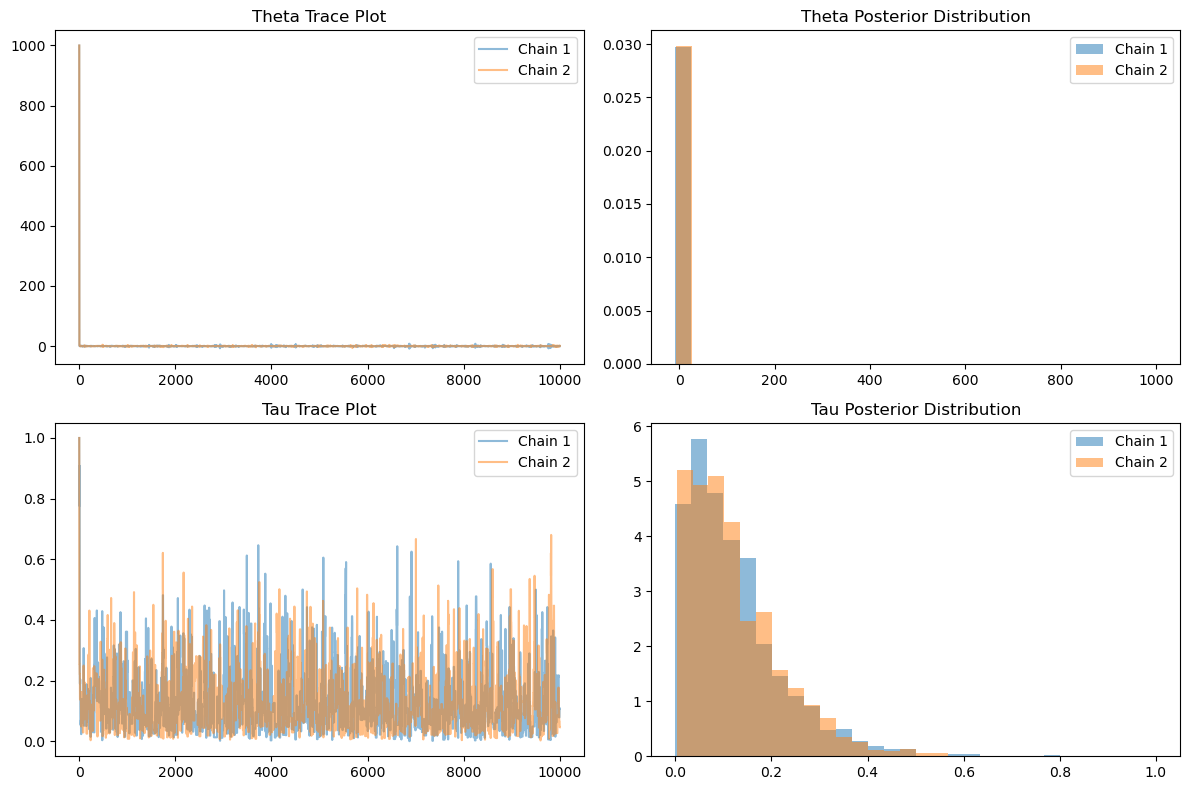

In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1) Generate Data
# ---------------------------------------------------------
n = 30              # sample size
true_mean = 0
true_std  = 1
x = stats.norm(loc=true_mean, scale=true_std).rvs(size=n)

# ---------------------------------------------------------
# 2) Define Prior Hyperparameters
# ---------------------------------------------------------
theta0   = 0        # (used only for reference if needed)
tau0_sq  = 1        # (used only for reference if needed)
alpha    = 2        # shape parameter for tau's Gamma prior
lambda_  = 1        # rate parameter for tau's Gamma prior

# Non-normal prior for theta:
# Here, a Uniform(-10, 10) prior => log-prior = 0 if theta in [-10,10], else -∞
def log_prior_theta(theta):
    return np.where((-10 <= theta) & (theta <= 10), 0.0, -np.inf)

# Gamma prior for tau
def log_prior_tau(tau):
    # Gamma(alpha, lambda): p(tau) ∝ tau^(alpha-1) exp(-lambda * tau)
    # => log(p(tau)) = (alpha-1)*log(tau) - lambda*tau
    return (alpha - 1.0)*np.log(tau) - lambda_*tau

# ---------------------------------------------------------
# 3) Joint Log Density (Posterior up to constant)
# ---------------------------------------------------------
def log_joint_density(theta_val, tau_val):
    if tau_val <= 0:
        return -np.inf  # tau must be positive
    # log-likelihood: x ~ Normal(theta, 1/tau)
    # => log-likelihood = -0.5 * tau * sum((x - theta)^2)
    log_lik = -0.5 * tau_val * np.sum((x - theta_val)**2)
    
    return log_prior_theta(theta_val) + log_prior_tau(tau_val) + log_lik

# ---------------------------------------------------------
# 4) Metropolis within Gibbs Settings
# ---------------------------------------------------------
C, G = 2, 10000  # Number of chains, number of samples
theta = np.zeros((C, G))
tau   = np.zeros((C, G))

# Initialize
theta[:, 0] = 1000.0  # Start with a large value for theta to see if chain moves
tau[:, 0]   = 1.0

# Standard deviation for truncated normal proposals
s = 1.0

# ---------------------------------------------------------
# 5) Metropolis within Gibbs Sampling
# ---------------------------------------------------------
for c in range(C):
    for g in range(1, G):
        
        # ---- (A) Metropolis-Hastings update for theta (non-normal prior) ----
        # Propose theta from Uniform(-10, 10) [This is a simple approach]
        theta_proposed = stats.uniform.rvs(loc=-10, scale=20)
        
        log_accept = (log_joint_density(theta_proposed, tau[c, g-1])
                      - log_joint_density(theta[c, g-1], tau[c, g-1]))
        
        if np.log(np.random.rand()) < log_accept:
            theta[c, g] = theta_proposed
        else:
            theta[c, g] = theta[c, g-1]
        
        # ---- (B) Metropolis-Hastings update for tau with dependent proposal ----
        tau_current = tau[c, g-1]
        # Create truncated normal distribution ensuring tau > 0
        a = -tau_current / s
        b = np.inf
        proposal_dist = stats.truncnorm(a=a, b=b, loc=tau_current, scale=s)
        tau_proposed  = proposal_dist.rvs()
        
        log_accept_2 = (log_joint_density(theta[c, g], tau_proposed)
                        - log_joint_density(theta[c, g], tau_current))
        
        # Because the proposal depends on tau_current, we must include
        # q(tau_current | tau_proposed) - q(tau_proposed | tau_current).
        # For simplicity, if the distribution is symmetrical in a local sense,
        # this ratio might be small, but we do it properly:
        log_q_forward = proposal_dist.logpdf(tau_proposed)
        # We need the reverse proposal distribution:
        rev_a = -tau_proposed / s
        rev_dist = stats.truncnorm(a=rev_a, b=np.inf, loc=tau_proposed, scale=s)
        log_q_backward = rev_dist.logpdf(tau_current)
        
        log_accept_2 += (log_q_backward - log_q_forward)
        
        if np.log(np.random.rand()) < log_accept_2:
            tau[c, g] = tau_proposed
        else:
            tau[c, g] = tau_current

# ---------------------------------------------------------
# 6) Results Visualization
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for c in range(C):
    # Trace plots
    axes[0, 0].plot(theta[c, :], alpha=0.5, label=f'Chain {c+1}')
    axes[1, 0].plot(tau[c, :], alpha=0.5, label=f'Chain {c+1}')
    
    # Posterior histograms
    axes[0, 1].hist(theta[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')
    axes[1, 1].hist(tau[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')

axes[0, 0].set_title("Theta Trace Plot")
axes[1, 0].set_title("Tau Trace Plot")
axes[0, 1].set_title("Theta Posterior Distribution")
axes[1, 1].set_title("Tau Posterior Distribution")
for ax in axes.flatten():
    ax.legend()

plt.tight_layout()
plt.show()

In a conventional Gibbs sampler, we typically need explicit full conditional distributions. While this works well in cases where conjugate priors make such derivations straightforward, it becomes challenging when those priors are not available. In contrast, a Metropolis-Hastings within Gibbs framework relies on proposal distributions rather than direct sampling from full conditionals. This flexibility enables the use of a wider range of priors (such as uniform, Laplace, or other non-normal forms) and also accommodates necessary constraints (for example, ensuring 𝜏 remains positive using truncated distributions). However, this approach involves calculating acceptance probabilities and carefully tuning the proposal mechanism to achieve efficient mixing.

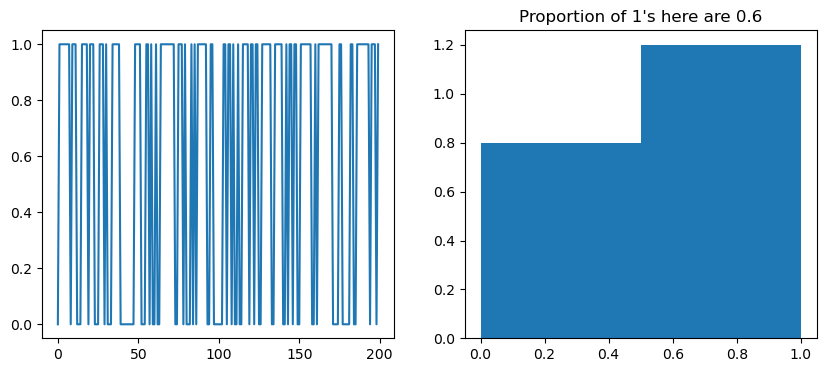

In [6]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

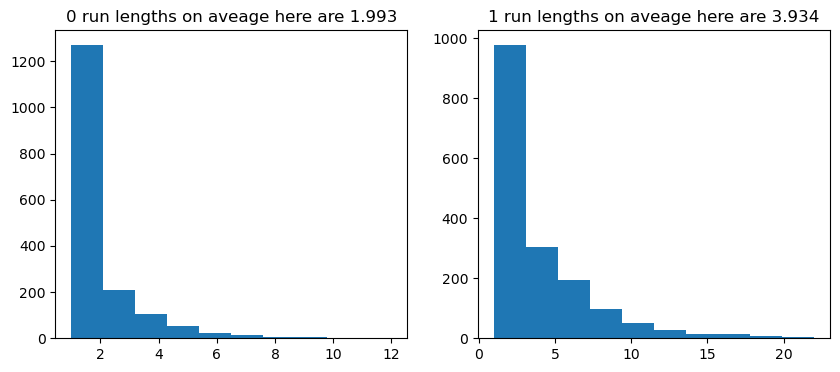

In [7]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));

# Q3

1. Context and Setup
This question deals with a simple two-state Metropolis--Hastings (MH) sampler, where the possible states of the chain are $0$ and $1$. We have:

$$
p(x) \;=\; \left(\frac{1}{3}\right)^{\,1 - x}\,\left(\frac{2}{3}\right)^{\,x},
$$

so that $p(x = 0) = \tfrac{1}{3}$ and $p(x = 1) = \tfrac{2}{3}$. 

A proposal distribution

$$
q\bigl(\tilde{x}^{(t)} \mid x^{(t-1)}\bigr),
$$

in the simplest symmetrical case, might be:

$$
q(\tilde{x} = 0 \mid x = 1) = \frac{1}{2}, \quad
q(\tilde{x} = 1 \mid x = 1) = \frac{1}{2}, \quad
q(\tilde{x} = 0 \mid x = 0) = \frac{1}{2}, \quad
q(\tilde{x} = 1 \mid x = 0) = \frac{1}{2}.
$$

In such a scenario, we want to derive the Metropolis--Hastings transition kernel $K$ of the Markov chain and show how the acceptance ratios lead to the specified probabilities.

2. Metropolis--Hastings Transition Kernel
At iteration $t$, given the current state $x^{(t-1)}$, the MH update first proposes a new state $\tilde{x}^{(t)}$ via 
$$
q(\tilde{x}^{(t)} \mid x^{(t-1)}).
$$
It then accepts or rejects this proposal with probability

$$
\alpha\bigl(x^{(t-1)}, \tilde{x}^{(t)}\bigr)
\;=\;\min\!\Bigl\{\,1,\;
  \frac{\,p\bigl(\tilde{x}^{(t)}\bigr)\,\;q\bigl(x^{(t-1)} \mid \tilde{x}^{(t)}\bigr)\,}
       {\,p\bigl(x^{(t-1)}\bigr)\,\;q\bigl(\tilde{x}^{(t)} \mid x^{(t-1)}\bigr)\,}
\Bigr\}.
$$

\noindent
If the proposal distribution $q$ is symmetric (i.e.\ $q(a \mid b) = q(b \mid a)$), then the ratio of proposal densities cancels out, leaving 
$$
\alpha = \min\!\Bigl\{1,\;\frac{p(\tilde{x}^{(t)})}{p(x^{(t-1)})}\Bigr\}.
$$
Once the acceptance step is decided, the chain moves to the new state $\tilde{x}^{(t)}$ with probability $\alpha$; otherwise it stays in $x^{(t-1)}$.

3. Deriving the 2$\times$2 Transition Matrix
For a two-state chain, the transition kernel can be written as a 2$\times$2 matrix:

$$
K \;=\;
\begin{bmatrix}
\Pr\bigl(x^{(t)} = 0 \to x^{(t+1)} = 0\bigr) & \Pr\bigl(x^{(t)} = 1 \to x^{(t+1)} = 0\bigr)\\[6pt]
\Pr\bigl(x^{(t)} = 0 \to x^{(t+1)} = 1\bigr) & \Pr\bigl(x^{(t)} = 1 \to x^{(t+1)} = 1\bigr)
\end{bmatrix}.
$$

Let us illustrate how one entry is computed (others follow similarly).

Example: $\Pr\bigl(x^{(t)}=1 \to x^{(t+1)}=1\bigr)$

With probability $q(\tilde{x}=1 \mid x=1)$, we propose $\tilde{x}=1$. If we propose the same state, we stay in $1$ automatically.
With probability $q(\tilde{x}=0 \mid x=1)$, we propose $\tilde{x}=0$. Then we accept $\tilde{x}=0$ with probability 
$$
\min\Bigl\{1,\;\frac{p(0)}{p(1)}\Bigr\}.
$$ 
If it is rejected, we remain in state 1.

Hence,

$$
\Pr\bigl(1 \to 1\bigr)
\;=\;
q(\tilde{x}=1 \mid x=1)\;\;+\;\;
q(\tilde{x}=0 \mid x=1)\,\Bigl[\,1-\alpha\bigl(1,0\bigr)\Bigr].
$$

If $q$ is symmetric and $\tfrac{p(0)}{p(1)} = \tfrac{(1/3)}{(2/3)} = \tfrac12$, then $\alpha(1,0) = \min\{1,1/2\}=1/2$. Suppose $q(\tilde{x}=1 \mid x=1) = 1/2$ and $q(\tilde{x}=0 \mid x=1)=1/2$. Then

$$
\Pr\bigl(1 \to 1\bigr)
\;=\;
\frac{1}{2} + \frac{1}{2}\Bigl(1 - \frac{1}{2}\Bigr)
\;=\;
\frac{1}{2} + \frac{1}{2} \times \frac{1}{2}
\;=\;
\frac{1}{2} + \frac{1}{4}
\;=\;
0.75.
$$

This matches the $(1,1)$ entry of the transition kernel given in the question.

4. ``Does $\,q(x^{(t-1)} \mid \tilde{x}^{(t)}) \,/\, q(\tilde{x}^{(t)} \mid x^{(t-1)})\,$ cancel?''
In general, the Metropolis--Hastings acceptance ratio contains a factor

$$
\frac{q\bigl(x^{(t-1)} \mid \tilde{x}^{(t)}\bigr)}{q\bigl(\tilde{x}^{(t)} \mid x^{(t-1)}\bigr)}.
$$

If $q$ is symmetric (i.e.\ $q(a \mid b) = q(b \mid a)$), then this ratio is $1$. Hence it does ``cancel out.'' If $q$ is not symmetric, you must keep that ratio in the acceptance probability. In the 2-state example above, if $q$ is $\tfrac12$ in both directions, then it is symmetric, and the ratio is $1$.

5. Conclusion and Connection to the Provided Transition Kernel}
By carefully enumerating the probabilities of staying in the current state or switching to the other state, and applying the acceptance/rejection step, we recover the specified transition matrix:

$$
K \;=\;
\begin{bmatrix}
  0.5 & 0.25\\[6pt]
  0.5 & 0.75
\end{bmatrix},
$$

depending on the exact labeling (row/column order) and the acceptance logic. The key takeaway is that if $q$ is symmetric, the proposal ratio cancels, making the acceptance ratio depend only on the ratio $\tfrac{p(\tilde{x})}{p(x^{(t-1)})}$. This leads directly to the values shown in the example probabilities (0.5, 0.25, 0.5, 0.75).